In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# BilinearSampler Test Field

In [16]:
def mesh(H, W):
    x, y= torch.arange(W), torch.arange(H)
    x = x.unsqueeze(0).repeat(H, 1)
    y = y.unsqueeze(1).repeat(1, W)
    xy = torch.stack((x/((W-1)/2)-1, y/((H-1)/2)-1 ), -1)
    return xy


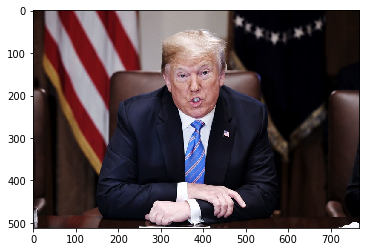

In [2]:
pimg = plt.imread('img/donald-trump-threatens-ex-obama-officials.jpg')
plt.imshow(pimg); plt.show()

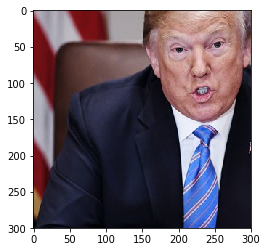

In [3]:
pimg = pimg[100:400, 150:450]
plt.imshow(pimg); plt.show()

In [4]:
timg = torch.from_numpy(pimg).type(torch.FloatTensor).permute(2,0,1)

pimg[:,:,0] - timg[0] 

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

## Creat the Mesh

In [20]:
xy = mesh(300,300); xy.shape

torch.Size([300, 300, 2])

In [21]:
simg = F.grid_sample( timg.unsqueeze(0), xy.unsqueeze(0))

In [22]:
(torch.abs(timg-simg.data)).sum()

3.765287270769477

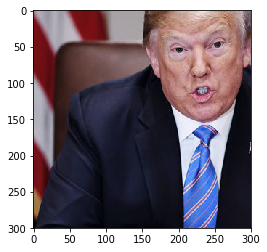

In [23]:
plt.imshow(simg.squeeze(0).permute(1,2,0).data.numpy()/255 ); plt.show()

## Funny Flip

In [24]:
xy[0,0], xy[-1, -1]
x, y = xy[:,:,0], xy[:,:,1]
xy = torch.stack((y,x),-1)

In [25]:
simg = F.grid_sample( timg.unsqueeze(0), xy.unsqueeze(0))

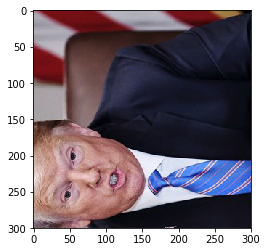

In [26]:
plt.imshow(simg.squeeze(0).permute(1,2,0).data.numpy()/255 ); plt.show()

## Test it with all zero (just sample the middle)

In [27]:
zeros = torch.zeros_like(xy.unsqueeze(0))

In [28]:
simg = F.grid_sample( timg.unsqueeze(0), zeros)

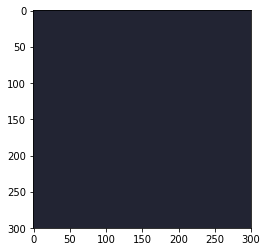

In [29]:
plt.imshow(simg.squeeze(0).permute(1,2,0).data.numpy()/255 ); plt.show()

In [5]:
from models import BilinearProj

SyntaxError: invalid syntax (conv_learner.py, line 56)

In [31]:
sampler = BilinearProj()

In [32]:
def mesh2(H, W):
    x, y= torch.arange(W), torch.arange(H)
    x = x.unsqueeze(0).repeat(H, 1)
    y = y.unsqueeze(1).repeat(1, W)
    #xy = torch.stack((x/((W-1)/2)-1, y/((H-1)/2)-1 ), -1)
    return x, y

In [33]:
x.shape

torch.Size([300, 300])

In [34]:
x, y= mesh2(300,300)
sampled = sampler(timg.unsqueeze(0), x.unsqueeze(0), y.unsqueeze(0))

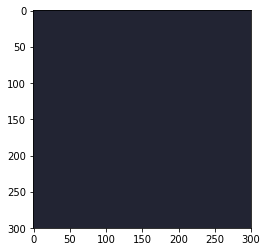

In [35]:
plt.imshow(simg.squeeze(0).permute(1,2,0).data.numpy()/255 ); plt.show()